In [1]:
from citrination_client import CitrinationClient
from os import environ

client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')

# Introduction to Queries

Queries allow you to search and download PIFs from Citrination.  By basing scripts on queries intead of local files, you can:
 1. Share data with your group without running internal infrastructure or worrying about portability
 1. Expand your queries to include data uploaded by other groups in your field
 1. Publish post-processing scripts backed by Citrination data to improve reproducibility

## Query interfaces

There are multiple interfaces to a unified backend based on elastic search:
 1. The website
 1. The python and java citrination clients 
 1. A REST API 
 
This tutorial will focus on the python citrination client

## `PifSystemReturningQuery`

Each search and download request is stored in a query object: the `PifSystemReturningQuery`.

A PifQuery is structured in the following hierarchical way:

```
PifSystemReturningQuery(
            size=0,
            query=DataQuery(
                dataset=DatasetQuery(
                    id=Filter(equal='151278')
                ),
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        filter=ChemicalFilter(
                            equal='C22H15NSSi')))))
                            ```
                            
see our API docs for more information: https://citrineinformatics.github.io/api-documentation/#tag/search

If you are working through the notebooks in the order they are presented on our [API Examples](https://citrination.org/learn/api-examples/) site, use the `dataset_id` from the previous Importing VASP calculations notebook in the query below. 

Otherwise, we can start with the [Bandgaps Dataset](https://citrination.com/datasets/1160/show_search), but feel free to use any public dataset.



In [3]:
from citrination_client import PifSystemReturningQuery, PifSystemQuery
from citrination_client import DataQuery, DatasetQuery, ChemicalFieldQuery, ChemicalFilter, Filter
from citrination_client import PropertyQuery, FieldQuery

#change dataset id below
my_dataset_id = 154987
bandgaps_dataset_id = 1160

query_dataset = PifSystemReturningQuery(size=5, 
                                        query=DataQuery(
                                            dataset=DatasetQuery(
                                                id=Filter(equal=str(my_dataset_id))
                                         )))
query_result = client.search.pif_search(query_dataset)
print("Found {} PIFs in dataset {}".format(query_result.total_num_hits, my_dataset_id))

Found 2 PIFs in dataset 154987


The result contains the matching PIFs:

In [4]:
from pypif.pif import dumps
pifs = [x.system for x in query_result.hits]
print(dumps(pifs[0], indent=2)[:550])

{
  "tags": [
    "my_first_upload"
  ],
  "category": "system.chemical",
  "qualityReport": {
    "body": "",
    "name": "",
    "postamble": "nowrap Summary:       Number of tests:   6\n                critical error:   0\n                         error:   0\n               serious warning:   0\n                       warning:   2\n                       caution:   0\n                recommendation:   1\n                   information:   1\n                       comment:   0\n                            ok:   2\n                not applicab


A `simple_chemical_search` query using the citrination client can accept lists of datasets to bring in data from collaborators:

In [6]:
my_dataset_id = 154987; another_dataset_id = 1160

query = client.generate_simple_chemical_query(include_datasets=[my_dataset_id, another_dataset_id], size=500)
retuls = client.search.pif_search(query)
print("Found {} PIFs in datasets {} and {}".format(
        query_result.total_num_hits, my_dataset_id, another_dataset_id
    ))

Found 2 PIFs in datasets 154987 and 1160


# Advanced Queries

Writing analysis and post-processing on top of PIFs lets us:
 1. Pull in data from collaborators and published sources
 1. Share our methodology with other researchers with data in PIFs

Let's actually do that!

## Real example: phase stability diagram

There are surely more Al-Cu binaries on Citrination.  We will:
 1. Find relevant data via the web interface
 2. Filter the data programatically with the query
 3. Extract the data using query extractions
 4. Add the data to our plot from before

## Search for relevant data

The exploratory search is usually best done on the website.  Tips and tricks:
 * "AlxCuy" searches for any Al-Cu binary
 * "energy" searches for properties with "energy" in their name

## Adding filters to the query

Now that we are querying beyond just our data, we need to filter down to records that contain Al-Cu energies.

### Filter by chemical formula

1. You can filter over known datasets
2. You can filter over all public data

In [7]:
#filtering over a known dataset by formula='CdTe'

res = client.pif_search(PifSystemReturningQuery(
            size=0,
            query=DataQuery(
                dataset=DatasetQuery(
                    id=Filter(equal='1160')
                ),
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        filter=ChemicalFilter(
                            equal='AlxCuy'))))))
print(res.total_num_hits)

0


In [9]:
#filtering by formula='AlxCuy'

query = PifSystemReturningQuery(
            size=10,
            query=DataQuery(
                simple='AlxCuy'))

query_result = client.search.pif_search(query)
print("Found {} PIFs".format(query_result.total_num_hits))

Found 139 PIFs


### Filter by property

We can do quick filtered searches with `citrination_client.simple_chemical_search`. It returns a `PifSearchResult` object as before, but with useful filter flags. See the docs for more info.




In [11]:
query = client.generate_simple_chemical_query(property_name='Formation Energy', chemical_formula='AlxCuy', size=500)
quicksearch1 = client.search.pif_search(query)
print("Found {} PIFs".format(quicksearch1.total_num_hits))

query = client.generate_simple_chemical_query(property_name=['Formation Energy', 'Enthalpy of Formation'], chemical_formula='AlxCuy', size=500)
quicksearch2 = client.search.pif_search(query)
print("Found {} PIFs".format(quicksearch2.total_num_hits))

Found 5 PIFs
Found 16 PIFs


In [12]:
from pypif.pif import dumps
print(dumps(quicksearch1.hits[1].system, indent=2))

{
  "category": "system.chemical",
  "references": [
    {
      "doi": "10.1016/j.commatsci.2012.02.002"
    },
    {
      "doi": "10.1016/j.commatsci.2012.02.005"
    }
  ],
  "uid": "5CA6B3488E258DB2E0A73ADDA2F97C4D",
  "properties": [
    {
      "name": "Structure designation",
      "scalars": [
        {
          "value": "CaF[2]"
        }
      ]
    },
    {
      "name": "Formation energy",
      "scalars": [
        {
          "value": "-0.1799"
        }
      ],
      "units": "eV/atom",
      "dataType": "COMPUTATIONAL"
    }
  ],
  "chemicalFormula": "CuAl2"
}


## Extract data from results using the query language

Multiple sources typically use multiple internal formats.  The query language is smart about crawling the PIFs for properties with the right names, while `pypif` is not.  Fortunately, you can use the query language to do data extraction as well!

### Using `extract_as`

In [13]:
query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy'),
                    ),
                    properties=PropertyQuery(
                        name=FieldQuery(
                            filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]),
                        value=FieldQuery(
                            extract_as="formation_enthalpy")
                    )
                )
            ))

res = client.search.pif_search(query)
print("Found {} PIFs".format(res.total_num_hits))
print([x.extracted for x in res.hits][0:2])

Found 16 PIFs
[{'formation_enthalpy': '-0.1889', 'formula': 'Cu3Al'}, {'formation_enthalpy': '-0.1799', 'formula': 'CuAl2'}]


A few notes:
 * `extract_as` extracts the field it is on (why we need value)
 * `extracted` is a dictionary from String keys to values; no units or uncertainty

## Real example: phase stability diagram

Let's create an Al-Cu phase diagram and add these points.

We'll start with some sample DFT data and create pifs out of the samples. Then, we'll add the new points found in our query above.

In [14]:
import os
from dfttopif import directory_to_pif

Cu_pif = directory_to_pif("./example_data/Cu.cF4")
Al_pif = directory_to_pif("./example_data/Al.cF4")
AlCu_pifs = [directory_to_pif(os.path.join("./example_data/", x))
             for x in os.listdir("./example_data/") if "Al" in x]

In [15]:
def enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu):
    return (energy - n_Al * energy_Al - n_Cu * energy_Cu) / (n_Al + n_Cu)

In [16]:
import re

def get_stoich(AlCu_formula):
    m = re.match(r"Al([0-9]*)Cu([0-9]*)", AlCu_formula)
    if m is not None:
        n_Al = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Cu = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    m = re.match(r"Cu([0-9]*)Al([0-9]*)", AlCu_formula)
    if m is not None:
        n_Cu = float(m.group(1)) if len(m.group(1)) > 0 else 1
        n_Al = float(m.group(2)) if len(m.group(2)) > 0 else 1
        return (n_Al, n_Cu)
    return (0, 0)

ReadView is a dictionary-like read-only view into a PIF that indexes members by name and elevates keys up the PIF hierarchy as long as they are unambiguous. For more info see the docs.

Here, we'll use ReadView to populate an array of `(Energy, formula)` tuples to build our phase diagram.

In [17]:
from pypif_sdk.readview import ReadView

energy_Al = ReadView(Al_pif)["Total Energy"].scalars[0].value / 4
energy_Cu = ReadView(Cu_pif)["Total Energy"].scalars[0].value

points = [(0.0, 0.0), (1.0, 0.0)]
for pif in AlCu_pifs:
    rv = ReadView(pif)
    energy = rv["Total Energy"].scalars[0].value
    n_Al, n_Cu = get_stoich(rv.chemical_formula)
    if n_Al == 0 and n_Cu == 0: continue
    points.append((
            n_Cu / (n_Cu + n_Al),
            enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu)
        ))

Now, let's add the new points from our queries above. 

In [18]:
new_points = []
for hit in res.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((
            n_Cu / (n_Cu + n_Al),
            float(hit.extracted["formation_enthalpy"])
        ))

Text(0,0.5,'$\\Delta H (eV/atom)$')

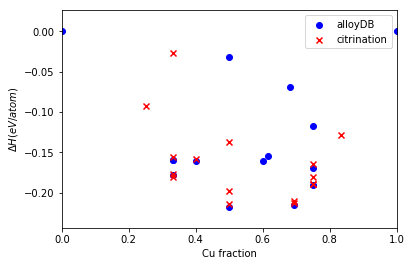

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(*zip(*points), color='blue', marker='o', label='alloyDB')
plt.scatter(*zip(*new_points), color='red', marker='x', label='citrination')
plt.legend(loc="best")
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")

### Filter by value

A few of the values in are mislabeled: they are called "Enthalpy of Formation" but are actually total energies (per atom).  We can filter them out by recognizing that all the Al-Cu binaries have enthalpy of formation above $-1.0 eV / $atom.

In [21]:
query = PifSystemReturningQuery(
            size=500,
            query=DataQuery(
                system=PifSystemQuery(
                    chemical_formula=ChemicalFieldQuery(
                        extract_as="formula",
                        filter=ChemicalFilter(equal='AlxCuy'),
                    ),
                    properties=PropertyQuery(
                        name=FieldQuery(
                            filter=[Filter(equal="Formation energy"), Filter(equal="Enthalpy of Formation")]),
                        value=FieldQuery(
                            extract_as="formation_enthalpy",
                            filter=[Filter(min=-1.0)])
                    )
                )
            ))

query_result = client.search.pif_search(query)

In [22]:
new_points = []
for hit in query_result.hits:
    n_Al, n_Cu = get_stoich(hit.extracted["formula"])
    new_points.append((
            n_Cu / (n_Cu + n_Al),
            float(hit.extracted["formation_enthalpy"])
        ))

This looks much better:

Text(0,0.5,'$\\Delta H (eV/atom)$')

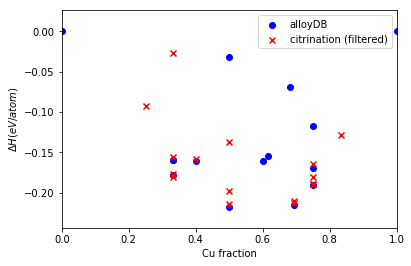

In [23]:

plt.scatter(*zip(*points), color='blue', marker='o', label='alloyDB')
plt.scatter(*zip(*new_points), color='red', marker='x', label='citrination (filtered)')
plt.legend()
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")